# mini-project: Automatic Speech Recognition(1/2)
We split the mini-project into two notebooks. 

This is ***1/2*** of the mini-project. Make sure to also complete and submit ***HuBERT_ASR.ipynb***.

***Credits***: ELENE 6820, Xilin Jiang(xj2289 at columbia) and Prof. Nima Mesgarani.

Rewritten from Yi Luo's ASR homework in 2021.

I acknowledge SpeechBrain [Tutorials](https://speechbrain.github.io/tutorial_basics.html) for reference and ChatGPT for rephrasing and testing.



---




## ASR Background

Automatic Speech Recognition (ASR) is probably the most famous task in speech processing. The task itself is simple - we need to build an *automatic* system that transcribes an audio clip into a sequence of words in a certain language, but the model design and the details can be very complicated.

As what you have learned in the course, conventional ASR systems contained multiple components. Typically we can broadly categories them into ***acoustic model*** and ***language model***, where the acoustic model maps the waveform (or any time-frequency representations) to a list of phonemes, and the language model needs to learn the temporal dependencies bewteen phonemes (phoneme-level language model) or words (word-level language model). Prior to the advances in deep learning, acoustic modeling was typically done by HMMs and Gaussian mixture models (HMM-GMMs), and the language model was typically done by famous statistical methods such as N-grams. People need to first train the acoustic model (with phoneme labels) and the language model independently and then combine them to get the full pipeline. The implementation of such pipelines can be complex and difficult if you don't have enough experience on it, so we will not ask you to do so in this course.

With the development of neural networks, the acoustic modeling part (HMM-GMM) can be well replaced by more advanced neural networks (HMM-DNN). Moreover, given a pretrained language model, the DNN acoustic model can be trained to maximize its performance on the given language model, which is something that GMMs cannot do. Sometimes people call this **end-to-end training**, as the DNN acoustic models are trained to maximize the ASR performance (i.e., minimize the word-error-rate (WER)) instead of phoneme recognition accuracy.

Sequence-to-sequence (Seq2Seq) models have provided another view for ASR - combine the acoustic model and the language model within a same neural network, and directly generate the character sequences. As the name implies, Seq2Seq models map one sequence to another sequence, and this is done by a deep neural network. In the task of ASR, the input sequence is the waveform (or spectrogram), and the output sequence is the words. In this pipeline, we don't really have a clear definition of "acoustic model" and "language model", and what we have is a neural network that takes waveform (or MFCC) as input and generating the probability for different characters in the output sequence. Such pipelines are not only end-to-end trained, but are also **end-to-end processed**, since now the language model part is also jointly optimized and directly generates the output characters. This is the so-called ***E2E ASR***, which is also one of the most popular research direction in the development of ASR systems. Several applications, e.g., Google voice search and Google Home/Amazon Alexa, have already deployed their E2E ASR systems to replace the conventional ones.

More recently, Self-supervised(**SSL**) speech representation learning has gained popularity as a promising approach for various speech processing tasks. The SSL encoder is trained on a large(e.g. years of) amount of unlabeled data using self-supervised methods to learn meaningful speech representations. Subsequently, the pretrained model can be adapted to another task with minimal(e.g. hours of) labeled data. Most popular self-supervised learning techniques, such as ***masked prediction***,  ***contrastive learning***, and ***generative modeling*** have been widely used in audio, image, and language domain. For speech processing, the most well-known SSL models include [wav2vec 2.0](https://arxiv.org/abs/2006.11477), [HuBERT](https://arxiv.org/abs/2106.07447), and [WavLM](https://arxiv.org/abs/2110.13900). The ASR models built on them achieve the [SOTA](https://paperswithcode.com/sota/speech-recognition-on-librispeech-test-other) performance on the LibriSpeech dataset. In Lecture 6 Speech Signal Representation, we briefly discussed self-supervised learning (SSL). Now, we will revisit this concept and explore how HuBERT features can be used for speech recognition. However, we will not implement and train an SSL model from scratch, as this would require significant computational resources and time (weeks or months on A100/V100 GPUs). Instead, we will leverage the benefits of large-scale pretraining and evaluate how using pretrained HuBERT can work in speech recognition systems.

## Environment and Tools

### 1. GPU

For this homework, we have made ***three*** important changes. First, we will be using **Google Colab**, which provides free GPU support. GPUs have much more cores and threads than CPUs, making them better suited for model training that involve a lot of matrix multiplication. In particular, PyTorch has GPU acceleration for NVIDIA GPUs with CUDA. The pre-installed PyTorch in Colab should have CUDA supported already.

You can get a free Tesla T4 after you click `Runtime->Change runtime type->Hardware accelerator(GPU)`. If you have a **personal or shared NVIDIA GPU**, feel free to use it instead(after you install PyTorch+CUDA). Verify that you have GPU support by 

In [1]:
!nvidia-smi
import torch
print(torch.cuda.is_available())

/bin/bash: nvidia-smi: command not found
False


Once you open the notebook in Google Colab, you can execute the cells just as you would in your local Jupyter notebook. However, please be aware that you only have ***~4 hours of free GPU access per day***. If you are not using the GPU, please consider changing the runtime to CPU. Alternatively, you can upload and run this homework on other(e.g. personal) Google accounts that you have access to.


You may encounter some common errors on GPU like 

`RuntimeError: CUDA Out of memory` 

choose a smaller batch size. Or, 

`RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!` 

you need to `.cuda()` or `.cpu()` your data and model. SpeechBrain package should already transfer them to GPU. You may need to transfer data back to CPU if you want to play some audios or do some visualization.

We expect more environment/package-related questions for this homework. Feel free to ask them on Ed or in OH. 

***Remember: You can always ask ChatGPT for help!***






### 2. SpeechBrain

The second change for this year's homework is the adoption of SpeechBrain for creating the model training and evaluation pipeline, instead of implementing everything from scratch. SpeechBrain is an open-source toolkit for speech processing, designed by Mila-Quebec AI Institute, and has been continuously growing since 2020. 

While you are already familiar with audio libraries like librosa and soundfile from previous assignments, you may ask what are the differences?

*Firstly*, SpeechBrain is implemented using PyTorch, which means you can use anything from PyTorch in your SpeechBrain implementation, and vice versa. You can run SpeechBrain modules on GPUs.


*Secondly*, SpeechBrain is a more high-level toolkit, which means you start 
from an experiment(an idea), to dataset and model, to data pipeline, model training and evaluation, and finally to data augmentation, model forward and loss function. For each step, SpeechBrain offers customizable functions and classes. 

*Thirdly*, in addition to library functions, SpeechBrain provides example model [implementations](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/lobes/models/conv_tasnet.py), pre-trained [checkpoints](https://huggingface.co/speechbrain/sepformer-wsj02mix), data [preparation](https://github.com/speechbrain/speechbrain/blob/develop/recipes/ESC50/esc50_prepare.py) and loading, and experiment [hyperparameters](https://github.com/speechbrain/speechbrain/blob/develop/recipes/LibriSpeech/ASR/transformer/hparams/conformer_small.yaml). By using the same model and hyperparameters, you can reproduce the results of a paper, if implemented by someone(authors or volunteers) in SpeechBrain.

In short, SpeechBrain prevents building existing wheels and improve reproducibility of published works.

You can read the

documentation: https://speechbrain.github.io

paper: https://arxiv.org/abs/2106.04624

github: https://github.com/speechbrain/speechbrain

of SpeechBrain.


---

Now, install SpeechBrain. If you find other missing packages, please install them manually.

(You may need to re-install it if you restart the notebook kernel.)

In [2]:
!pip install speechbrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 9.9 MB/s eta 0:00:00


### 3. LibriSpeech, LAS, and HuBERT

In this homework, we will assess the performance of LAS and HuBERT models on a specific portion of the LibriSpeech dataset. LAS is a significant advancement in the field of end-to-end automatic speech recognition, while HuBERT is a well-known self-supervised speech model developed by Meta. We will delve deeper into them as we proceed.

LibriSpeech is currently one of the most popular speech datasets, containing around 1000 hours of 16kHz read English speech, and is commonly used in various speech-related tasks including speech recognition, speech separation, and text-to-speech. The dataset was prepared by Johns Hopkins University and can be freely accessed and downloaded from the [openSLR](https://www.openslr.org/12) website. 

More information about the LibriSpeech dataset can be found in the paper at
http://www.danielpovey.com/files/2015_icassp_librispeech.pdf.


Unfortunately, we cannot experiment on the full 1000-hour corpus due to limit of time and computation. Instead, we will use a subset for training and validation from [Mini LibriSpeech](https://www.openslr.org/31/). You can use the following command to download the Mini LibriSpeech dataset to your Google Drive. If you are running the notebook on your local environment, there's no need to mount Google Drive. Just make sure to download the dataset and place it in the appropriate directory. In case you restart the notebook kernel, you will have to mount the Google Drive again to access the data and codes.

In [3]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/HW6_part2/
%mkdir data ; ls

Mounted at /content/drive/
/content/drive/MyDrive/HW6_part2
mkdir: cannot create directory ‘data’: File exists
data	 HuBERT_ASR.ipynb  manifests  old_part2.pdf
hparams  LAS_ASR.ipynb	   models     save


In [4]:
# Download and unzip data. You only need to do it once.
#!wget -P data https://www.openslr.org/resources/31/train-clean-5.tar.gz && wget -P data https://us.openslr.org/resources/31/dev-clean-2.tar.gz && wget -P data https://us.openslr.org/resources/12/test-clean.tar.gz

In [5]:
#!tar -xf data/train-clean-5.tar.gz -C data && tar -xf data/dev-clean-2.tar.gz -C data && tar -xf data/test-clean.tar.gz -C data && rm -rf data/*.tar.gz

You can find `train-clean-5`, `dev-clean-2`, `test-clean` in your `data/LibriSpeech` folder.

In [6]:
#!ls data/LibriSpeech

***Introduction ends. Homework begins in the next cell.***

# LAS ASR with Speechbrain

In [7]:
import os
import re
import datetime

import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
import pdb
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The first half of the notebook serves as a tutorial of SpeechBrain. Follow the cells carefully and make sure you understand the code logic, as you will be using SpeechBrain to implement ASR model training and evaluation.

Let's start with the idea of ***recipes***. Remember that in the previous homework, we wrote all the code for the model, data, and loss in a single notebook and defined all the hyperparameters there. However, this is a terrible way of ML development as it can become challenging to make changes to the model, switch to a different dataset, or experiment with various hyperparameters. Modifying the same notebook(or .py) for every new experiment can lead to self-confusion and errors, eventually leading wrong results.

ML toolkits like SpeechBrain separate an experiment into different files, including the runner program, hyperparameter files, dataset manifests, and model definition files. The first three are combined to form a recipe. Recipes can be created by the user or obtained from others. By running the recipe, we can reproduce someone else's results or modify the configuration file to experiment with different models or hyperparameters.

Runner programs and hyperparameter files are NOT one-to-one. We can 

```
python train_something.py hparams/something.yaml
python train_otherthing.py hparams/something.yaml
python train_something.py hparams/otherthing.yaml
```
as long as they are compatiable. 


## 1. Configuration

I prepared hyperparameter files for this homework in `hparams` folder. Configurations are written in YAML. You don't need to worry about the syntax because YAML is easy to learn on-the-fly and some special grammars and tags are for SpeechBrain only. 

In [8]:
HPARAM_FILE = 'hparams/las.yaml'
!ls hparams

hubert.yaml  las.yaml


Let's take a closer look of `hparams/las.yaml`. 

First, we can define hyperparameters as integers, floats, strings, lists, and other python data types.
```
n_epoch: 150
batch_size: 8
lr: 1.0e-3
```
We can refer(`!ref`) to hyperparameters defined in the same file.
```
save_folder: !ref <save_root>/<experiment>/<time_stamp>

train_dataloader_opts:
    batch_size: !ref <batch_size>
```
We can also point(`!name`) to a local or library function or class or instantiate(`!new`) a class object(e.g. layer and model).

```
phi: !new:torch.nn.Linear
    in_features: !ref <hidden_dim> + <n_mfcc>
    out_features: !ref <n_mfcc>

normalizer: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

opt_class: !name:torch.optim.Adam
    lr: !ref <lr>

```

***You can add or change hyperparameters, but you need to reload the file.***

***I strongly recommend defining all hyperparameters in `hparams/las.yaml`, not somewhere else in the notebook.***



Hyperparameters defined in YAML can be overwritten in the terminal by specifying a new value for the hyperparameter using flags such as `--n_epoch 10`. For this notebook, we simulate running the experiment in the terminal by using `argv` to set the experiment time stamp.


In [9]:
time_stamp = datetime.datetime.now().strftime('%Y-%m-%d+%H-%M-%S')
print(f'Experiment Time Stamp: {time_stamp}')
argv = [HPARAM_FILE, '--time_stamp', time_stamp,'--lr','0.0001']

hparam_file, run_opts, overrides = sb.parse_arguments(argv)

with open(HPARAM_FILE) as f:
    hparams = load_hyperpyyaml(f, overrides)

Experiment Time Stamp: 2023-04-16+22-47-09


We just load YAML to a dictionary `hparams`.

## 2. Models

***Please review the lectures and read the document old_part2.pdf*** to ensure a comprehensive understanding of Listen, Attend and Spell (LAS). For your convenient, I borrowed some modules into `models` folder. They are automatically instantiated when we load `hparams` in the previous cell. We will pass them to SpeechBrain later.

This is how we instantiate them in YAML:
```
listener: !new:models.las.DeepResidualLSTM
    input_size: !ref <n_mfcc>
    hidden_size: !ref <hidden_dim>
    num_layers: 2
    bidirectional: true
    packed_input: false
```

Note: using the SpeechBrain package can be more convenient than implementing everything from scratch in old_part2. One specific example is that SpeechBrain automatically pads tensors, which eliminates the need for using torch.nn.utils.rnn to pad tensors manually. In the case of any conflicts between the current notebook and the old_part2.pdf, please follow the current notebook.

Besides, I wrote a simple tokenizer. The vocabulary used for the task includes 26 uppercase English letters, space and apostrophe, and BOS and EOS symbols.

```
vocab: [
    ' ', "'", 'A', 'B', 'C', 'D', 'E', 
    'F', 'G', 'H', 'I', 'J', 'K', 'L', 
    'M', 'N', 'O', 'P', 'Q', 'R', 'S', 
    'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    '/', # end of sequence
    '#', # begin of sequence
]
```

Our LAS model needs to predict 28 tokens and EOS. The tokenizer will stop decoding once EOS is encountered.

Here is one example usage of the tokenizer. The last index is always `eos_idx = 28`.

In [10]:
t = 'HELLO SPEECH RECOGNITION'
t_enc = hparams['tokenizer'].encode(t)
t_dec = hparams['tokenizer'].decode(t_enc)
print(t_enc)
print(t_dec)

[9, 6, 13, 13, 16, 0, 20, 17, 6, 6, 4, 9, 0, 19, 6, 4, 16, 8, 15, 10, 21, 10, 16, 15, 28]
HELLO SPEECH RECOGNITION


I think I have included all the modules we need for LAS. You can define more in the `models` folder and use them in the same way.

## 3. Data

Creating and loading data manifest files for large datasets can be a highly advantageous approach, as it enables the consistent loading of data regardless of varying file structures or file locations.

Typically, generating manifest files involves some manual effort👷, but I have already prepared the manifest files for you in the `manifests` folder. These manifest files can be in either CSV or JSON format, with each row or element corresponding to one data sample. The attributes of each sample can be accessed using the keys provided in the manifest file.

In [11]:
!ls manifests

dev-clean-2.json  las-train.json      test-clean.json
las-test.json	  las-train-val.json  train-clean-5.json


This is one utterance in `las-train.json`. We can include attributes based on our needs. Make sure the `file_path` is correct, or you need to either change the manifest or your dataset location.
```
"6930-81414-0005": {
    "file_path": "./data/LibriSpeech/test-clean/6930/81414/6930-81414-0005.flac",
    "words": "WHAT WAS THAT",
    "spkID": "speaker_6930",
    "length": 29040
},
```



We will use `las-train.json` for training, `las-train-val.json` for seen-speaker validation, and `las-test.json` for unseen-speaker testing. They only include a subset of the files we have downloaded, because we set LAS `max_decoding_length: 50`, so we cannot decode more than 50 characters for an utterance.

`las-train.json` contains 600 utterances; `las-train-val.json` contains 100 utterances from `las-train.json`; `las-test.json` contains 100 unseen utterances. Typically, people report WER of a ASR model on unseen speakers, but as you will see at the end of this notebook, our LAS model performs poorly on the `las-test.json`.

Are we done with the data?

No. We only have raw data now. We need to do some data preprocessing. In SpeechBrain, it is done in the data pipeline. For ASR task, we define a `text_pipeline` to tokenize words with our tokenizer.

In [12]:
@sb.utils.data_pipeline.takes('words')
@sb.utils.data_pipeline.provides('words', 'tokens_list', 'tokens_eos', 'tokens')
def text_pipeline(words):
    yield words
    tokens_list = hparams['tokenizer'].encode(words, eos=False)
    yield tokens_list
    tokens_eos = torch.LongTensor(
        tokens_list 
        + [hparams['eos_idx']] 
        + [hparams['ignore_idx']] * (hparams['max_decoding_length']-1-len(tokens_list))
    )
    yield tokens_eos
    tokens = torch.LongTensor(tokens_list)
    yield tokens

We will use `tokens_eos` as a list of classification targets for LAS to predict. It looks like 

```
[9, 6, 13, 13, 16, 0, 20, 17, 6, 6, 4, 9, 0, 19, 6, 4, 16, 8, 15, 10, 21, 10, 16, 15, 28, 30, 30, ..., 30]
```

`[9, 6, ..., 15, 28]` is the valid token list(ended with EOS) that LAS needs to predict correctly. 

We pad it to `max_decoding_length` by `ignore_idx: 30`, which is ignored in the loss function.

```
loss_fn: !new:torch.nn.CrossEntropyLoss
     ignore_index: !ref <ignore_idx>
```


It's time to define `DynamicItemDataset` in place of PyTorch datasets in the previous homework. 

In [13]:
from speechbrain.dataio.dataset import DynamicItemDataset

# Create Train Dataset
train_manifest_path = hparams['train_manifest_path']
print(f'Creating training set from {train_manifest_path}')
train_set = DynamicItemDataset.from_json(train_manifest_path)
train_set.add_dynamic_item(
    sb.dataio.dataio.read_audio, takes='file_path', provides='signal'
)
# We only sort utterances by signal length to reduce the overhead of padding
train_set = train_set.filtered_sorted(sort_key='length', select_n=hparams['n_train'])
train_set.add_dynamic_item(text_pipeline)
train_set.set_output_keys(
    ['id', 'signal', 'words', 'tokens_list', 'tokens_eos', 'tokens']
)
    
# Create Valid Dataset
valid_manifest_path = hparams['valid_manifest_path']
print(f'Creating validation set from {valid_manifest_path}')
valid_set = DynamicItemDataset.from_json(valid_manifest_path)
valid_set.add_dynamic_item(
    sb.dataio.dataio.read_audio, takes='file_path', provides='signal'
)
valid_set = valid_set.filtered_sorted(sort_key='length', select_n=hparams['n_valid'])
valid_set.add_dynamic_item(text_pipeline)
valid_set.set_output_keys(
    ['id', 'signal', 'words', 'tokens_list', 'tokens_eos', 'tokens']
)

# Create Test Dataset 
test_manifest_path = hparams['test_manifest_path'] 
print(f'Creating validation set from {test_manifest_path}')
test_set = DynamicItemDataset.from_json(test_manifest_path)
test_set.add_dynamic_item(
    sb.dataio.dataio.read_audio, takes='file_path', provides='signal'
)
test_set = test_set.filtered_sorted(sort_key='length', select_n=hparams['n_test'])
test_set.add_dynamic_item(text_pipeline)
test_set.set_output_keys(
    ['id', 'signal', 'words', 'tokens_list', 'tokens_eos', 'tokens']
)

Creating training set from manifests/las-train.json
Creating validation set from manifests/las-train-val.json
Creating validation set from manifests/las-test.json


Our data pipeline contains both audio pipeline 
```
train_set.add_dynamic_item(
    sb.dataio.dataio.read_audio, takes='file_path', provides='signal'
)
```
and text pipeline
```
train_set.add_dynamic_item(text_pipeline)
```
and output the following items for each sample.
```
train_set.set_output_keys(
    ['id', 'signal', 'words', 'tokens_list', 'tokens_eos', 'tokens']
)
```

Audios in the batch needs to be padded to the same length, so we sort the dataset by audio lengths to speedup inference.

```
train_set = train_set.filtered_sorted(sort_key='length', select_n=hparams['n_train'])
```

## 4. Brain

Finally, we reach to the **Brain** class of Speech**Brain**. Brain 🧠 is ***the most important class*** of the experiment. We implement everything related to the model forward, loss function, optimization and evaluation inside the Brain class.

What is Brain? You are familiar with `torch.nn.Module` in PyTorch. The Module class is a wrapper of model layers, and you define the computation from input x to output y(and the backwards). `sb.core.Brain` is a wrapper of the entire model training and evaluation. You can have multiple `torch.nn.Module` in the Brain. You can optimize them with different losses. Brain also helps you keep the best checkpoint and log results to your disk or to the network.

### You need to complete the `LasASR` Brain class below.


#### TODO(1/10) 

In `listen_attend_spell`, implement training with teacher forcing and evaluation without it.

#### TODO(2/10)

Implement `listen`(encoding). 

#### TODO(3/10) and (4/10)

Implement `attend_spell` (decoding). 

#### TODO(5/10)

Call the loss function in `compute_objectives`. 


***Hint***: Read the paper and call the modules in the YAML. I give the variables and modules the same names as the paper.

In [14]:
import torch.nn.functional as F
class LasASR(sb.core.Brain):
    
    ################################################################################
    def listen(self, x, x_lens):    
        # TODO: Implement listen
        #raise NotImplementedError
        h_ts,_ = self.hparams.listener(x)
        h_ts = h_ts.contiguous()
        return h_ts
    
    def attend_spell(self, h_ts, c_prev, y_prev, lens, rnn_state_prev=None):
        # TODO: Implement attend_spell        
        #raise NotImplementedError
        
        # Step 0: Extract character embedding y_prev
        y_prev_emb = self.hparams.embedder(y_prev.view(-1))
        #concat y_prev and encoder output
        concat_input = torch.cat([y_prev_emb,c_prev],dim=1)
        # Step 1: s_new, rnn_state_new = RNN(y_prev, c_prev, rnn_state_prev)
        s_output, rnn_state_new = self.hparams.rnn(concat_input.unsqueeze(1), rnn_state_prev)
        # Step 2: c_new = AttentionContext(h, s_new)
        # Need a linear projection 'phi' on s_new to match the dimension of h.
        s_new = self.hparams.phi(s_output.squeeze(1))
        # compute similarity
        sim =  h_ts.bmm(s_new.unsqueeze(2)).squeeze()
        
        #normalized  weights
        attention_weight = [F.softmax(sim[i,:lens[i]],dim = 0).view(-1,1)  for i in range(sim.shape[0])]
        #weighted encoder output
        c_new = [ (h_ts[i,:lens[i]] * attention_weight[i] ).sum(0).unsqueeze(0) for i in range(sim.shape[0])]
        c_new = torch.cat(c_new,0)
        # Hint: For i in the batch:
        #    (1). Calculate the similarity[i](inner product) between phi(s_new)[i] 
        #    and every valid(0:lens[i]) frames of h[i]
        #    (2). attention[i] is the normalized similarity across valid frames
        #    (3). c_new[i] is h[i] weighted by attention[i] for all valid frames   
  
        # Step 3: p_new = CharacterDistribution(s_new, c_new)
        
        prob_input = torch.cat([s_output.squeeze(1),c_new],1)
        p_new = self.hparams.character_distribution(prob_input)
        return p_new, rnn_state_new, c_new

    def listen_attend_spell(self, x, lens, labels=None, teacher_forcing=True):
        
        batch_size = x.shape[0]
        
        # Estimated label probabilties and best labels
        est_probs = []
        est_labels = []
        
        # Listen
        h_ts = self.listen(x, lens)
        # Attend and Spell
        for step in range(self.hparams.max_decoding_length):
            if step == 0:
                # Use BOS as the beginning label
                label_prev = torch.ones(batch_size, device=x.device).long() * self.hparams.bos_idx
                # Initialize a zero context vector
                c_prev = torch.zeros(batch_size, self.hparams.n_mfcc, device=h_ts.device)
                rnn_state_prev = None
            else:
                # TODO: Implement teacher forcing in training.
                # If teacher_forcing, use true last label,
                # Else, use estimated last label.\
                #raise NotImplementedError
                if teacher_forcing:
                    label_prev = labels[:,step-1]
                else:
                    label_prev = est_labels[-1]

            # Decode
            p_new, rnn_state_new, c_new = self.attend_spell(h_ts, c_prev, label_prev, lens, rnn_state_prev)
            # update states
            rnn_state_prev = rnn_state_new
            c_prev = c_new
            # Select the token index with the highest probability
            y_new = torch.argmax(p_new, dim=1)
            est_probs.append(p_new.unsqueeze(1))
            est_labels.append(y_new.unsqueeze(1))
 
            
        est_probs = torch.cat(est_probs, 1)  # (B, N, V-1) (no BOS)
        est_labels = torch.cat(est_labels, 1)  # (B, N)
        
        return est_probs, est_labels
    
    ################################################################################
    
    def on_fit_start(self):
        super().on_fit_start()
        
    def compute_forward(self, batch, stage):
        batch = batch.to(self.device)
        wavs, wav_lens = batch.signal
        tokens_eos, _ = batch.tokens_eos
        # Compute MFCC
        mfcc = self.modules.compute_features(wavs) # (B, N, n_mfcc=40)
        mfcc = mfcc.permute(0, 2, 1).contiguous() # (B, n_mfcc, N)
        
        # Compute valid MFCC lengths
        mfcc_lens = torch.ones_like(wav_lens) \
            * mfcc.shape[1] \
            * wav_lens # max_mfcc_lens * ratio
        mfcc_lens = mfcc_lens.long()
        
        # Adaptive normalization
        current_epoch = self.hparams.epoch_counter.current
        mfcc = self.modules.normalizer(mfcc, wav_lens, epoch=current_epoch)
        
        est_probs, est_labels = self.listen_attend_spell(
            mfcc, mfcc_lens, tokens_eos, 
            teacher_forcing=(stage==sb.Stage.TRAIN)
        )
        
        return est_probs, est_labels

    def compute_objectives(self, predictions, batch, stage):
        ids = batch.id
        tokens_eos, _ = batch.tokens_eos
        est_probs, est_labels = predictions
        batch_size = est_probs.shape[0]
        tgt = tokens_eos.view(-1,)
        est = est_probs.view(-1,self.hparams.vocab_size-1).to(torch.float32)
        # TODO: Calculate the loss between the predicted and true tokens
        loss = self.hparams.loss_fn(est,tgt)
        #raise NotImplementedError
        with torch.no_grad():
        #if stage != sb.Stage.TRAIN:
            # Decode token terms to words
            predicted_words = [
                self.hparams.tokenizer.decode(est_label).split(' ') 
                for est_label in est_labels
            ]
            target_words = [wrd.split(' ') for wrd in batch.words]
            #print words
            for idx,val in enumerate(predicted_words):
              p = ''.join(val)
              t = ''.join(target_words[idx])
              print(f'idx:{idx} \n pred: {p} \n target: {t}')
            self.wer_metric.append(ids, predicted_words, target_words)
            self.cer_metric.append(ids, predicted_words, target_words)
            
        return loss

    def evaluate_batch(self, batch, stage):
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        if stage != sb.Stage.TRAIN:
            self.wer_metric = self.hparams.wer_computer()
            self.cer_metric = self.hparams.cer_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        # Compute stats
        stage_stats = {'loss': stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats['WER'] = self.wer_metric.summarize('error_rate')
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")

        if stage == sb.Stage.VALID:
            self.checkpointer.save_and_keep_only(
                meta={'WER': stage_stats['WER'], 'epoch': epoch},
                min_keys=['WER'],
            )

        elif stage == sb.Stage.TEST:
            with open(self.hparams.wer_file, 'w') as w:
                self.wer_metric.write_stats(w)
                
        print(f'Epoch {epoch}: ', stage, stage_stats) 

    def fit_batch(self, batch):
        outputs = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
        loss.backward()
        if self.check_gradients(loss): # grad is clipped here
            self.optimizer.step()
        self.optimizer.zero_grad()
        with torch.no_grad():
          loss.gra
        return loss.detach().cpu()


I have coded most of the training and evaluation for you. 

Here are some **TLDR**s. Please refer them back in the code.


1.  We put models into a dictionary `self.modules`. It is defined in our YAML. We can run them individually by calling the name  

```
    y = self.modules.model_name(x)
```

2.  We add trainable models to `self.checkpointer ` in the YAML. We keep the checkpoint of the lowest WER in the validation set.             

```
    self.checkpointer.save_and_keep_only(
        meta={'WER': stage_stats['WER'], 'epoch': epoch},
        min_keys=['WER'],
    )
```

3.  SpeechBrain has `Stage.TRAIN`, `Stage.VALID` and `Stage.TEST`. Each epoch first enters `Stage.TRAIN` on `train_set` and then `Stage.VALID` on `valid_set`. SpeechBrain only enters `Stage.TEST` in `brain.evaluate`. We can define different behaviors based on stages. For example, we do not decode tokens to save time in `Stage.TRAIN`.



```
    if stage != sb.Stage.TRAIN:
        # Decode token terms to words
        predicted_words = [
            self.hparams.tokenizer.decode(est_label).split(' ') 
            for est_label in est_labels
        ]
```

4.  `on_stage_start` is called at the start of every epoch. `on_fit_start` is called before the first epoch.

5.  `compute_forward` and `compute_objectives` are the two most important functions to implement. `compute_forward` returns outputs given inputs. `compute_objectives` calculate the losses given the outputs and targets. They are called back-to-back in `fit_batch` and `evaluate_batch`.

You can find the source [code](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/core.py#L351) and the awesome picture below in the [paper](https://arxiv.org/abs/2106.04624).


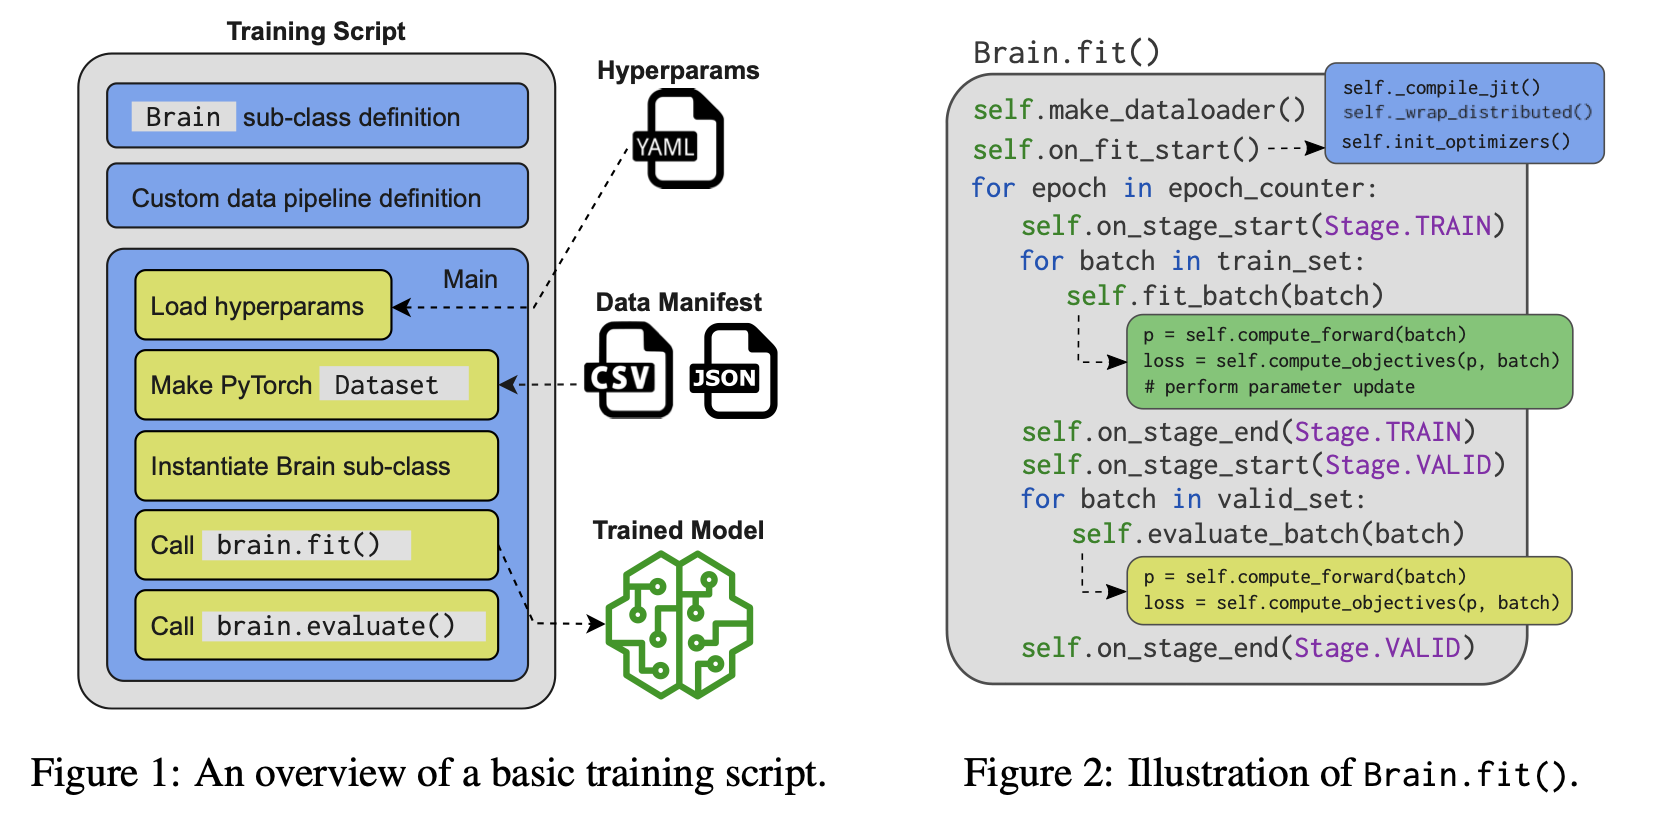

## 5. Experiment

Instantiate a Brain object. Usually you only need one Brain for one experiment.

In [15]:
brain = LasASR(
    hparams['modules'], 
    hparams=hparams, 
    opt_class=hparams['opt_class'],
    run_opts=run_opts,
    checkpointer=hparams['checkpointer']
)

RuntimeError: ignored

Train your model.

***Hint***: Be patient. it takes me >50 epochs and >100 epochs to reach a WER below 100 and 50 with my hyperparameters in the YAML.

In [ ]:
brain.fit(
    epoch_counter=hparams['epoch_counter'],
    train_set=valid_set,
    valid_set=valid_set,
    train_loader_kwargs=hparams['train_dataloader_opts'],
    valid_loader_kwargs=hparams['valid_dataloader_opts'],
)

**TODO(6/10)**. Evaluate your model on  `las-train-val`. You need to score a ***WER $\leq 25$*** on the validation set for full points.

`speechbrain.utils.metric_stats.ErrorRateStats` automatically logs the target and predicted words into `brain.hparams.wer_file`. 

You can also find your latest and the best model checkpoints in the same folder. SpeechBrain will automatically load the best model.

(One experiment creates one folder. You can delete the folders you don't want to keep.)

In [ ]:
brain.hparams.wer_file = brain.hparams.valid_wer_file
brain.evaluate(
    valid_set,
    test_loader_kwargs=hparams['valid_dataloader_opts'],
    min_key='WER'
) 

**Still (6/10)**.  Find one utterance which the model recognizes correctly and another which the model recognizes incorrectly. 

Play the audios and show the reference and predicted texts. For the texts, you can copy and paste from the WER file generated by SpeechBrain. 

In [ ]:
# TODO

**TODO(7/10)**. Evaluate the model on  `las-test`. You may find a much higher WER on unseen speakers. 

In [ ]:
brain.hparams.wer_file = brain.hparams.test_wer_file
brain.evaluate(
    test_set,
    test_loader_kwargs=hparams['test_dataloader_opts'],
    min_key='WER'
)

***Try to explain why?***